## Jupyter -> Data analysis and Web scraping

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL for EPL match results
url = "https://fbref.com/en/comps/9/schedule/Premier-League-Scores-and-Fixtures"

# Send GET request
headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, "html.parser")

# Find match table
table = soup.select_one("table.stats_table")

# Extract match data correctly
matches = []
for row in table.find_all("tr")[1:]:  # Skip header row
    cols = row.find_all("td")
    if len(cols) < 10:
        continue  # Skip incomplete rows

    date = cols[1].text.strip()
    home_team = cols[3].text.strip()
    score = cols[5].text.strip()  # Match score
    away_team = cols[7].text.strip()
    venue = cols[9].text.strip()

    matches.append([date, home_team, score, away_team, venue])

# Convert to DataFrame
df = pd.DataFrame(matches, columns=["Date", "Home Team", "Score", "Away Team", "Venue"])

# Display Title and First 10 Matches
print("\n🔹 Premier League - Match Fixtures 🔹\n")
print(df.head(10).to_string(index=False))

# Save Data to CSV
df.to_csv("epl_match_results.csv", index=False)

print("\n Data successfully saved to epl_match_results.csv!")


🔹 Premier League - Match Fixtures 🔹

      Date       Home Team Score       Away Team                   Venue
2024-08-16  Manchester Utd   1–0          Fulham            Old Trafford
2024-08-17    Ipswich Town   0–2       Liverpool    Portman Road Stadium
2024-08-17   Newcastle Utd   1–0     Southampton          St James' Park
2024-08-17 Nott'ham Forest   1–1     Bournemouth         The City Ground
2024-08-17         Everton   0–3        Brighton           Goodison Park
2024-08-17         Arsenal   2–0          Wolves        Emirates Stadium
2024-08-17        West Ham   1–2     Aston Villa          London Stadium
2024-08-18       Brentford   2–1  Crystal Palace Gtech Community Stadium
2024-08-18         Chelsea   0–2 Manchester City         Stamford Bridge
2024-08-19  Leicester City   1–1       Tottenham      King Power Stadium

 Data successfully saved to epl_match_results.csv!


In [2]:
# Split Score into Home & Away Goals safely
df[['Home Goals', 'Away Goals']] = df['Score'].str.split("–", expand=True)

# Convert to integers, handling errors
df['Home Goals'] = pd.to_numeric(df['Home Goals'], errors='coerce')
df['Away Goals'] = pd.to_numeric(df['Away Goals'], errors='coerce')

# Drop rows where goals couldn't be parsed
df = df.dropna(subset=["Home Goals", "Away Goals"]).astype({"Home Goals": int, "Away Goals": int})

# Classify Match Results
df['Result'] = df.apply(lambda x: "Home Win" if x["Home Goals"] > x["Away Goals"]
                        else ("Away Win" if x["Home Goals"] < x["Away Goals"] else "Draw"), axis=1)

# --- SORTING OPTIONS ---
# Sort matches by Date (oldest first)
df = df.sort_values(by="Date")

# --- FILTERING OPTIONS ---
# View matches for a specific team
team_name = "Liverpool"  # Change team name here
team_matches = df[(df["Home Team"] == team_name) | (df["Away Team"] == team_name)]
print(f"\n📌 Matches involving {team_name}:\n")
print(team_matches.to_string(index=False))



📌 Matches involving Liverpool:

      Date       Home Team Score       Away Team                     Venue  Home Goals  Away Goals   Result
2024-08-17    Ipswich Town   0–2       Liverpool      Portman Road Stadium           0           2 Away Win
2024-08-25       Liverpool   2–0       Brentford                   Anfield           2           0 Home Win
2024-09-01  Manchester Utd   0–3       Liverpool              Old Trafford           0           3 Away Win
2024-09-14       Liverpool   0–1 Nott'ham Forest                   Anfield           0           1 Away Win
2024-09-21       Liverpool   3–0     Bournemouth                   Anfield           3           0 Home Win
2024-09-28          Wolves   1–2       Liverpool          Molineux Stadium           1           2 Away Win
2024-10-05  Crystal Palace   0–1       Liverpool             Selhurst Park           0           1 Away Win
2024-10-20       Liverpool   2–1         Chelsea                   Anfield           2           1 Home

In [3]:
# View matches with a specific result type (Home Win, Away Win, Draw)
match_result = "Draw"  # Change to "Away Win" or "Draw"
filtered_matches = df[df["Result"] == match_result]
print(f"\n📊 {match_result} Matches:\n")
print(filtered_matches.to_string(index=False))




📊 Draw Matches:

      Date       Home Team Score       Away Team                        Venue  Home Goals  Away Goals Result
2024-08-17 Nott'ham Forest   1–1     Bournemouth              The City Ground           1           1   Draw
2024-08-19  Leicester City   1–1       Tottenham           King Power Stadium           1           1   Draw
2024-08-25     Bournemouth   1–1   Newcastle Utd             Vitality Stadium           1           1   Draw
2024-08-31    Ipswich Town   1–1          Fulham         Portman Road Stadium           1           1   Draw
2024-08-31 Nott'ham Forest   1–1          Wolves              The City Ground           1           1   Draw
2024-08-31         Arsenal   1–1        Brighton             Emirates Stadium           1           1   Draw
2024-09-01         Chelsea   1–1  Crystal Palace              Stamford Bridge           1           1   Draw
2024-09-14          Fulham   1–1        West Ham               Craven Cottage           1           1   Draw
2

In [4]:
# View top-scoring matches (sorted by total goals)
df["Total Goals"] = df["Home Goals"] + df["Away Goals"]
top_scoring_matches = df.sort_values(by="Total Goals", ascending=False).head(5)
print("\n🔥 Top Scoring Matches:\n")
print(top_scoring_matches.to_string(index=False))


🔥 Top Scoring Matches:

      Date Home Team Score    Away Team                     Venue  Home Goals  Away Goals   Result  Total Goals
2024-12-22 Tottenham   3–6    Liverpool Tottenham Hotspur Stadium           3           6 Away Win            9
2024-10-05 Brentford   5–3       Wolves   Gtech Community Stadium           5           3 Home Win            8
2024-08-25    Wolves   2–6      Chelsea          Molineux Stadium           2           6 Away Win            8
2024-10-26 Brentford   4–3 Ipswich Town   Gtech Community Stadium           4           3 Home Win            7
2024-11-30  West Ham   2–5      Arsenal            London Stadium           2           5 Away Win            7


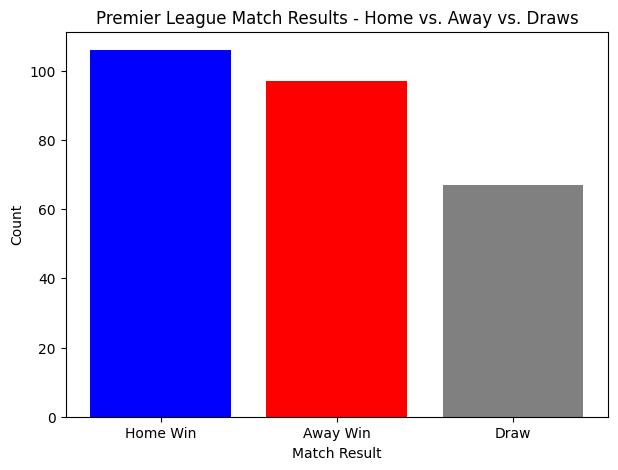

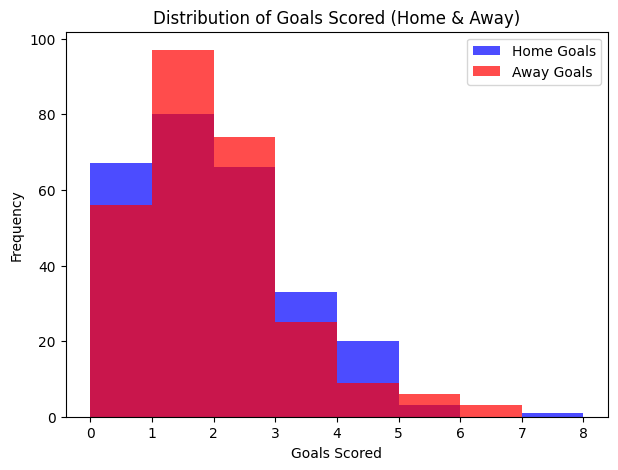

In [5]:
import matplotlib.pyplot as plt

# Ensure score column is valid
if not df["Score"].isnull().all():
    # Split Score into Home & Away Goals safely
    df[['Home Goals', 'Away Goals']] = df['Score'].str.split("–", expand=True)

    # Convert to integers, handling errors by replacing with NaN
    df['Home Goals'] = pd.to_numeric(df['Home Goals'], errors='coerce')
    df['Away Goals'] = pd.to_numeric(df['Away Goals'], errors='coerce')

    # Drop rows where goals couldn't be parsed
    df = df.dropna(subset=["Home Goals", "Away Goals"]).astype({"Home Goals": int, "Away Goals": int})

    # Classify Match Results
    df['Result'] = df.apply(lambda x: "Home Win" if x["Home Goals"] > x["Away Goals"]
                            else ("Away Win" if x["Home Goals"] < x["Away Goals"] else "Draw"), axis=1)

    # Count Match Results
    result_counts = df['Result'].value_counts()

    # Plot Bar Chart: Home Wins vs. Away Wins vs. Draws
    plt.figure(figsize=(7, 5))
    plt.bar(result_counts.index, result_counts.values, color=['blue', 'red', 'gray'])
    plt.title("Premier League Match Results - Home vs. Away vs. Draws")
    plt.xlabel("Match Result")
    plt.ylabel("Count")
    plt.show()
else:
    print("⚠️ No valid scores found, skipping result calculations.")
    
    
# 📊 Extra Visualization: Goals Scored by Home & Away Teams
plt.figure(figsize=(7, 5))
plt.hist(df["Home Goals"], bins=range(0, df["Home Goals"].max() + 2), alpha=0.7, color="blue", label="Home Goals")
plt.hist(df["Away Goals"], bins=range(0, df["Away Goals"].max() + 2), alpha=0.7, color="red", label="Away Goals")
plt.title("Distribution of Goals Scored (Home & Away)")
plt.xlabel("Goals Scored")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [6]:
import requests
import pandas as pd

# Understat API for Premier League players
url = "https://understat.com/main/getPlayersStats"

# Request headers
headers = {"User-Agent": "Mozilla/5.0"}

# Send POST request with season parameter
data = {
    "league": "EPL",
    "season": "2024"
}
response = requests.post(url, headers=headers, data=data)

# Convert JSON response to dictionary
json_data = response.json()

# Extract player stats
players = json_data["response"]["players"]

# Convert data to DataFrame
df = pd.DataFrame(players)

# Select relevant columns (excluding clean sheets)
df = df[["player_name", "team_title", "goals", "assists"]]

# Convert numeric values to integers
df[["goals", "assists"]] = df[["goals", "assists"]].astype(int)

# **Top Goal Scorers**
top_goals = df.nlargest(10, "goals")[["player_name", "team_title", "goals"]]
print("\n⚽ Top Goal Scorer (Season - 2024):\n")
print(top_goals)

# **Top Assists**
top_assists = df.nlargest(10, "assists")[["player_name", "team_title", "assists"]]
print("\n🎯 Most Assists (Season - 2024):\n")
print(top_assists)



⚽ Top Goal Scorer (Season - 2024):

            player_name               team_title  goals
0         Mohamed Salah                Liverpool     25
1        Erling Haaland          Manchester City     20
2        Alexander Isak         Newcastle United     19
3            Chris Wood        Nottingham Forest     18
4          Bryan Mbeumo                Brentford     15
5           Cole Palmer                  Chelsea     14
6         Matheus Cunha  Wolverhampton Wanderers     13
7  Jean-Philippe Mateta           Crystal Palace     12
8           Yoane Wissa                Brentford     12
9       Justin Kluivert              Bournemouth     12

🎯 Most Assists (Season - 2024):

          player_name         team_title  assists
0       Mohamed Salah          Liverpool       17
50        Bukayo Saka            Arsenal       10
383  Antonee Robinson             Fulham       10
35      Son Heung-Min          Tottenham        9
133  Mikkel Damsgaard          Brentford        9
89     Anthon